In [74]:
# IMPORTS
import glob
from imdb import IMDb
from itertools import cycle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import nltk
import numpy as np
import random
import statistics
import subprocess
import textclean
import unicodedata

from __future__ import print_function
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from scipy.stats import binom
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import AffinityPropagation
from textclean import textclean

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/karen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/karen/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
# CONSTANTS
NUM_FOLDS = 10
ACL_PATH = "aclImdb_v1/aclImdb/{}"
ACL_FOLDER_PATHS = [
    ACL_PATH.format("train/unsup/*"),
    ACL_PATH.format("train/pos/*"),
    ACL_PATH.format("train/neg/*"),
    ACL_PATH.format("test/pos/*"),
    ACL_PATH.format("test/neg/*")
]
ACL_URL_PATHS = [
    ACL_PATH.format("train/urls_unsup.txt"),
    ACL_PATH.format("train/urls_pos.txt"),
    ACL_PATH.format("train/urls_neg.txt"),
    ACL_PATH.format("test/urls_pos.txt"),
    ACL_PATH.format("test/urls_neg.txt")
]
PANG_POS_PATH = "POS-tokenized/POS/*"
PANG_NEG_PATH = "NEG-tokenized/NEG/*"
SEED = 0
NUM_FOLDS = 10
POS = 1
NEG = -1
R = 5000

# Functions

### Fetch Data

In [113]:
from nltk.tokenize import TweetTokenizer
def _get_docs_from_folder(folder_path, url_file_name=None, pretokenised=False):
    if url_file_name != None:
        move_id_dict = _get_movie_number_to_movie_id(url_file_name)
    files = glob.glob(folder_path)
    folder_documents = []
    tknzr = TweetTokenizer()
    for file_name in files:
        with open(file_name) as fp:
            doc_words = []
            if pretokenised:
                doc_words = [word.strip("\n") 
                             for word in fp.readlines()
                             if word]
            else:
                document = fp.read()
#                 doc_words = nltk.word_tokenize(document)
                doc_words = filter(None, tknzr.tokenize(document))
            
            if url_file_name == None:
                folder_documents.append(doc_words)
            else:
                movie_number = int(file_name.split("/")[-1].split("_")[0])
                folder_documents.append(
                    (move_id_dict[movie_number], doc_words))
                
    return folder_documents

def _get_movie_number_to_movie_id(url_file_name):
    movie_id_dict = {}
    with open(url_file_name) as fp:
        for index, line in enumerate(fp.readlines()):
            # Each line is expected to be a url such as:
            # http://www.imdb.com/title/tt0018515/usercomments
            movie_id = line.split("/")[4].lstrip("t")
            movie_id_dict[index] = movie_id
    return movie_id_dict

In [4]:
def get_embeddings_training_set(folder_paths_list, url_paths_list):
    all_docs = []
    for folder_path, url_path in zip(folder_paths_list, url_paths_list):
        folder_documents = _get_docs_from_folder(
            folder_path, url_path, pretokenised=False)
        all_docs.extend(folder_documents)
    return all_docs


In [5]:
def get_pang_dataset(pos_path, neg_path):
    pos_data = _get_docs_from_folder(pos_path, url_file_name=None, pretokenised=True)
    neg_data = _get_docs_from_folder(neg_path, url_file_name=None, pretokenised=True)
    
    validation_set = []
    test_and_training_docs = []
    for i, pos_and_neg_doc in enumerate(zip(pos_data, neg_data)):
        pos_doc, neg_doc = pos_and_neg_doc
        
        # Obtain validation set.
        if i%10 == 0:
            validation_set.append((pos_doc, POS))
            validation_set.append((neg_doc, NEG))
        else:
            test_and_training_docs.append((pos_doc, neg_doc))
        
    # Split remaining data into folds.
    data_set = {}
    for fold_index in range(NUM_FOLDS):
        data_set[fold_index] = []
    for i, (pos_doc, neg_doc) in enumerate(test_and_training_docs):
        data_set[i%NUM_FOLDS].append((pos_doc, POS))
        data_set[i%NUM_FOLDS].append((neg_doc, NEG))
    return validation_set, data_set

### Doc2Vec Classification

In [6]:
def train_doc2vec_model(training_set, epochs=10, dm=0, window=1, feature_size=100, hs=0):
    """Trains the Doc2Vec model
    
    Args:
        training_set: A list of (movie_id, [word, list, ...]) tuples.
    """
    documents = [TaggedDocument(doc, movie_id) 
                 for movie_id, doc in training_set]
    model = Doc2Vec(documents, seed=SEED, dbow_words=1, 
                    epochs=epochs, workers=4, dm=dm, window=window, feature_size=feature_size, hs=hs)
    return model

In [7]:
def store_docs_as_embeddings(dataset, doc2vec_model, name_of_file):
    with open(name_of_file, "w+") as fp:
        for document in dataset:
            doc_words, sentiment = document
            feature_vector = doc2vec_model.infer_vector(doc_words)
            feature_values = ["{}:{}".format(index + 1, value)
                              for index, value 
                              in enumerate(feature_vector)]
            line = "{} {}\n".format(sentiment, 
                                  " ".join(feature_values))
            fp.write(line)

In [8]:
def run_svm(training_set, test_set, doc2vec_model):
    training_file_name = "training_embeddings.txt"
    test_file_name = "test_embeddings.txt"
    model_file_name = "model_file.txt"
    predictions_file_name = "predictions.txt"
    
    if (doc2vec_model == None):
        print("ERROR: SVM with counts not yet supported!")
        print("Please spcify model.")
        return
    else:
        store_docs_as_embeddings(training_set, doc2vec_model,
                                 training_file_name)
        store_docs_as_embeddings(test_set, doc2vec_model, 
                                 test_file_name)
    # TRAIN
    subprocess.call(["svm_light/svm_learn", 
                     training_file_name, 
                     model_file_name])
    
    # CLASSIFY
    subprocess.call(["svm_light/svm_classify",
                     test_file_name,
                     model_file_name,
                     predictions_file_name])
    
    # TEST
    results = []
    with open(predictions_file_name) as pred_fp:
        for test_doc in test_set:
            doc_words, doc_sentiment = test_doc
            result = float(pred_fp.readline())
            if np.sign(result) == doc_sentiment:
                results.append(1)
            else:
                results.append(0)
    return results

### Testing

In [9]:
def permutation_test(baseline_results, system_results, subset_count=R):
    """Runs the permutation test on two sets of results.
    
    Args:
        baseline_results: The classification results for the 
            baseline.
        system_results: The classification results for the new 
            system. The files should be in the same order as
            in baseline_results.
        epochs: number of iterations.
    
    Returns:
        p-value.
    """
    if len(baseline_results) != len(system_results):
        print("Need equal number of results for perm test!")
        return
    
    # Get mean difference of true results.
    base_mean_difference = _mean_difference(
        baseline_results, system_results)
    
    # Generate random sample indices to swap.
    test_indices = [random.randint(0, len(baseline_results) -1)
                   for _ in range(subset_count)]
    
    # Count number of times swapping leads to a greater or equal
    # mean.
    exceeded_base_count = 0
    for test_index in test_indices:
        flip = random.choice([True, False])
        if flip:
            new_mean_difference = _mean_difference(
                baseline_results, system_results, swap=test_index)
            if new_mean_difference >= base_mean_difference:
                exceeded_base_count += 1
        else:
            exceeded_base_count += 1
    
    # Return probability.
    return (exceeded_base_count + 1)/float(subset_count + 1)
        
        
def _mean_difference(results_1, results_2, swap=-1):
    mean_1 = 0
    mean_2 = 0
    for i, (val_1, val_2) in enumerate(zip(results_1, results_2)):
        if swap == i:
            mean_1 += val_2
            mean_2 += val_1
        else:
            mean_1 += val_1
            mean_2 += val_2
    mean_1 /= float(len(results_1))
    mean_2 /= float(len(results_2))
    return abs(mean_1 - mean_2)

In [10]:
def accuracy(results):
    return statistics.mean(results) * 100

In [11]:
def cross_validate_data_set(data_set):
    """ Yields data set organised into training and test sets.
    
    Args:
        data_set: a dict mapping fold number to fold data.
        
    Returns: 
        A tuple (training_set, test_set). Each of these entries
        represents a list of docs (a list of list of strings).
    """
    for test_num in data_set.keys():
        training_set = []
        test_set = []
        for fold_num, curr_fold in data_set.items():
            if fold_num == test_num:
                test_set = curr_fold
            else:
                training_set.extend(curr_fold)
        yield (training_set, test_set)

In [12]:
def grid_search(embeddings_training_set, 
                svm_training_set, svm_test_set,
                dm_list=[], window_list=[], epochs_list=[], feature_size_list=[], hs_list=[]):
    """Train Doc2Vec on a bunch of parameters and test SVM on this.
    
    Each input is a list, defining the parameter to test.
    Results are stored in a file.
    
    dbow: 1 got distributes memory. Otherwise for dbow. 
    window: The maximum distance between the current and 
    predicted word within a sentence.
    epochs: number of iterations.
    """
    with open("RESULTS-COPY.txt", "w+") as fp:
        for hs in hs_list:
            for dm in dm_list:
                for window in window_list:
                    for epochs in epochs_list:
                        for feature_size in feature_size_list: 
                            params_string = "dm={}; window={}; epochs={}; feature_size={}\n".format(
                                dm, window, epochs, feature_size)
                            fp.write(params_string)
                            print(params_string)
                            doc2vec_model = train_doc2vec_model(
                                embeddings_training_set,
                                dm=dm, window=window, epochs=epochs, feature_size=feature_size)
                            results = run_svm(svm_training_set, 
                                              svm_test_set, 
                                              doc2vec_model)
                            results_string = map(str, results)
                            results_string = " ".join(results_string)
                            results_string = "{}\n".format(results_string)
                            fp.write(results_string)
                            print(results_string)
                            accuracy_string = "Accuracy is: {}\n\n".format(accuracy(results))
                            fp.write(accuracy_string)
                            print(accuracy_string)
    

### Visualisation

In [13]:
def reduce_dimensions(data, dimensions):
    return TSNE(n_components=dimensions).fit_transform(data)

In [195]:
def create_2d_plot(vectors, labels):
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [vector[0] for vector in vectors]
    ys = [vector[1] for vector in vectors]
    ax.scatter(xs, ys)
    for x, y, label in zip(xs, ys, labels):
        ax.annotate(label, (x, y))
    plt.show()

### Analysis

In [148]:
def find_most_common_words(document_list, num_words, 
                           word_type=None):
    """
    Args:
        document_list: A list of (id, [word, list,..]) pairs
    """
    
    
    # Apply part of speech tag filter
#     document_list = [_remove_empty_strings(document)
#                      for fold_documents in pang_folds.values()
#                      for (document, _) in fold_documents]
    if word_type == None:
        word_list = [word 
                     for document in document_list
                     for word in document]
    else:
        tagged_doc_list = [nltk.pos_tag(document)
                           for (_, document) in document_list]
        word_list = [word
                     for document in tagged_doc_list
                     for (word, tag) in document
                     if tag.startswith(word_type)]

    # Count words
    word_counts = dict()
    for word in word_list:
        if word not in word_counts:
            word_counts[word] = 0
        word_counts[word] = word_counts[word] + 1
    
    # Extract X most common
    word_count_list = [(count, word) 
                       for word, count 
                       in word_counts.items()]
    word_count_list.sort(reverse=True)
    most_common_words = word_count_list[:num_words]
    
    return [word for (_, word) in most_common_words]

def _remove_empty_strings(words_list):
    return [word for word in words_list if word]

# Executing Code

In [114]:
# GET DATA SETS
print("Loading ACL training set...")
embeddings_training_set = get_embeddings_training_set(
    ACL_FOLDER_PATHS, ACL_URL_PATHS)
print("Fetched {} docs.".format(len(embeddings_training_set)))

print("Loading Pang validation set...")
validation_set, pang_folds = get_pang_dataset(
    PANG_POS_PATH, PANG_NEG_PATH)
print("Fetched {} validation docs and ".format(len(validation_set)))
print("{} folds with {} docs each.".format(len(pang_folds), 
                                            len(pang_folds[0])))

Loading ACL training set...
Fetched 100000 docs.
Loading Pang validation set...
Fetched 200 validation docs and 
10 folds with 180 docs each.


In [22]:
# TRAIN DOC2VEC MODEL
print("Training Doc2Vec model...")
doc2vec_model = train_doc2vec_model(embeddings_training_set, epochs=10, dm=10, window=15, feature_size=100, hs=0)
print(doc2vec_model)

Training Doc2Vec model...
Doc2Vec(dbow+w,d100,n5,w15,mc5,s0.001,t4)


In [24]:
print("Running on validation set...")        
temp_training_set = [doc for fold in pang_folds.values()
                    for doc in fold]
results = run_svm(temp_training_set, validation_set, 
                   doc2vec_model)
print("The accuracy is {}%.".format(accuracy(results)))

Running on validation set...
The accuracy is 86.0%.


In [151]:
# OBTAIN WORD VECTORS OF INTEREST
def plot_most_common_words(document_list, num_words, 
                           word_type=None):    
    # Get common words
    print("Getting most common words...")
    most_common_words = find_most_common_words(
        document_list, num_words, word_type)
    word_vectors = [doc2vec_model.wv.get_vector(word)
                    for word in most_common_words]
    reduced_vectors = reduce_dimensions(word_vectors, 2)
    
    print("Plotting words...")
    # Plot word vectors
    fig = plt.figure()
    fig.set_size_inches(18.5, 15.5)
    ax = fig.add_subplot("111")
    xs = [vector[0] for vector in reduced_vectors]
    ys = [vector[1] for vector in reduced_vectors]
    ax.scatter(xs, ys)
    for x, y, label in zip(xs, ys, most_common_words):
        ax.annotate(label, (x, y))
    plt.show()

[u'/', u'>', u'br', u'<', u'"', u'movie', u'film', u'time', u'story', u'people', u'way', u'movies', u'characters', u'films', u'character', u'plot', u'life', u'scene', u'scenes', u"It's", u'something', u'thing', u'end', u'man', u'actors', u"I'm", u'years', u'show', u'*', u'lot', u'part', u'nothing', u'acting', u'director', u'things', u'fact', u'action', u'cast', u'horror', u'role', u"I've", u'comedy', u'series', u'work', u'world', u'love', u"it's", u'times', u'music', u'minutes', u'script', u'bit', u'performance', u'guy', u'anything', u'point', u'one', u'i', u'kind', u'family', u'TV', u'course', u'woman', u'anyone', u'DVD', u'girl', u'sense', u'place', u'effects', u'reason', u'money', u'job', u'book', u'John', u'actor', u'day', u'audience', u'someone', u'idea', u'A', u'fun', u'everything', u'version', u'screen', u'wife', u'fan', u'everyone', u'year', u'performances', u'Hollywood', u'kids', u'friends', u's', u'moments', u'production', u'line', u'couple', u'women', u'death', u'men', u'hom

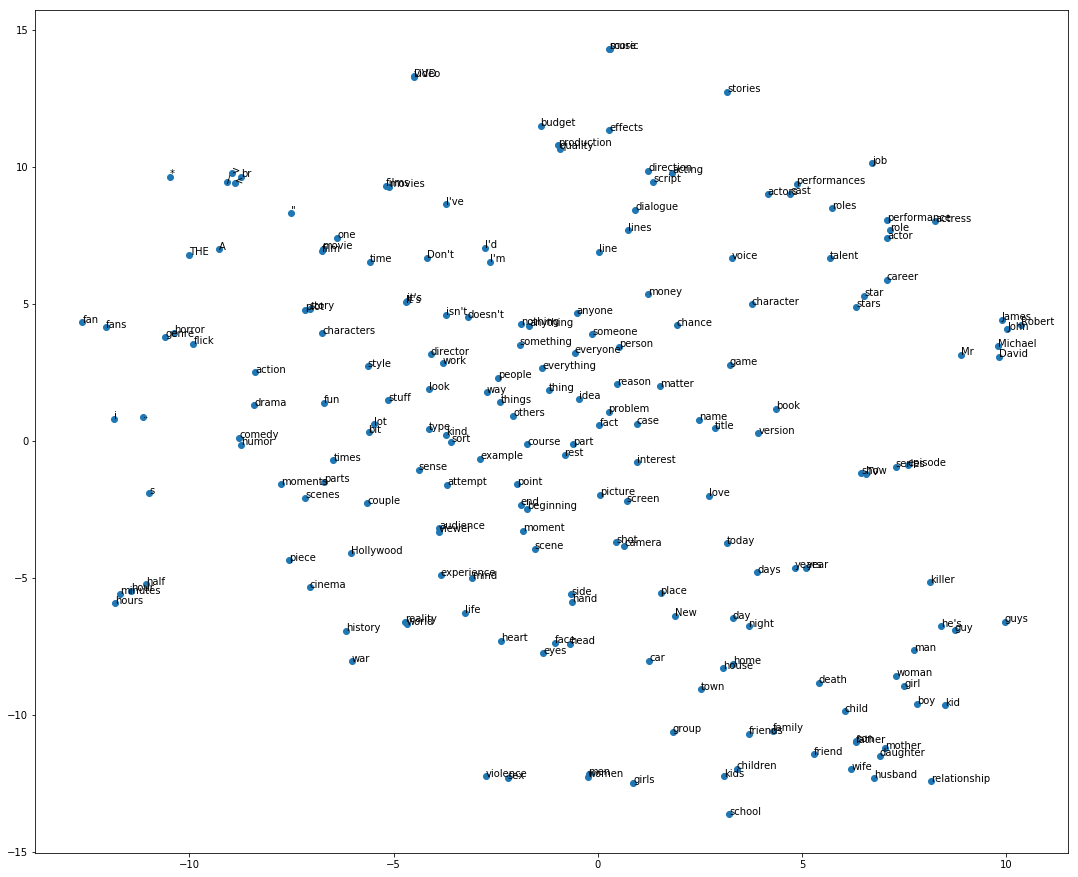

In [150]:
# PLOT WORD VECTORS 

plot_most_common_words(embeddings_training_set, 200, 
                       word_type="NN")

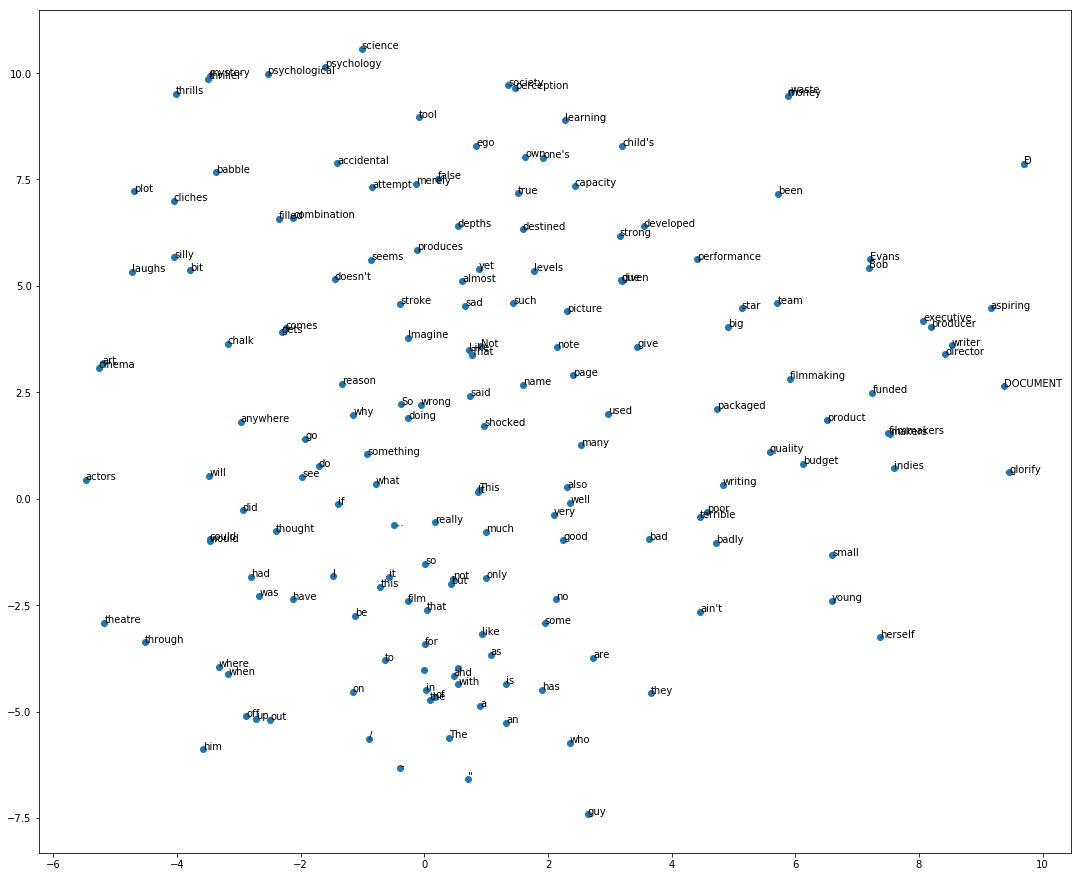

In [207]:
def plot_words_in_document(document):
    doc_vector = doc2vec_model.infer_vector(document)

    words = []
    word_vectors = []
    for word in set(document):
        try:
            vector = doc2vec_model.wv.get_vector(word)
            words.append(word)
            word_vectors.append(vector)
        except:
            pass
    
    words.append("DOCUMENT")
    word_vectors.append(doc_vector)

    reduced_vectors = reduce_dimensions(word_vectors, 2)
    create_2d_plot(reduced_vectors, words)
    
# plot_words_in_document(pang_folds[1][0][0])
plot_words_in_document(embeddings_training_set[3][1])

In [209]:
embeddings_training_set[3]

('0277412',
 [u'This',
  u'film',
  u'is',
  u'packaged',
  u'as',
  u'a',
  u'psychological',
  u'thriller',
  u',',
  u'yet',
  u'it',
  u'has',
  u'no',
  u'thrills',
  u'and',
  u'the',
  u'depths',
  u'of',
  u'the',
  u'psychology',
  u'used',
  u'in',
  u'the',
  u'writing',
  u'are',
  u'that',
  u'of',
  u'a',
  u'small',
  u"child's",
  u'capacity',
  u'.',
  u'The',
  u'plot',
  u'comes',
  u'off',
  u'very',
  u'silly',
  u',',
  u'and',
  u'this',
  u'film',
  u'is',
  u'a',
  u'waste',
  u'on',
  u'so',
  u'many',
  u'levels',
  u'.',
  u'The',
  u'film',
  u'had',
  u'a',
  u'good',
  u'dp',
  u',',
  u'good',
  u'director',
  u',',
  u'a',
  u'big',
  u'name',
  u',',
  u'and',
  u'a',
  u'good',
  u'budget',
  u'.',
  u'So',
  u'where',
  u'did',
  u'it',
  u'go',
  u'wrong',
  u',',
  u'well',
  u'the',
  u'writing',
  u'was',
  u'terrible',
  u'filled',
  u'with',
  u'cliches',
  u'and',
  u'babble',
  u'and',
  u'the',
  u'plot',
  u'really',
  u"doesn't",
  u'go',
